# Exploration de typologie d'événements

Exploration en fonction du pays, de la date et de la classification

À noter que au vu des effectifs les statistiques ne sont pas significatives (test du Chi-2 impossible)


In [1]:
import pandas as pd
import sqlite3 as sql
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

import scipy.stats as stats

In [2]:
### Define the path to the file (a string in a variable 'db_file')
# if the data directory label is at the same level as the notebook,
# then the path is 'data/astronomers_import.db'
db_file_address = '../../../Data_base_donnee/Base_donnee/cycle_manifestation.db'

In [3]:
### This ist the query that produces the data to be analysed.
# It has to be adapted to each use case
q2 = """
SELECT e.pk_evenement, e.nom, e."type" type_even, 
CASE
	when e."type" like 'manif%'	
	then 'manif'
	when e."type" = 'meeting'
	then 'meeting'
	else 'autre'
END as classif,
e.date as date_debut, e.date as date_fin, l.pays 
FROM evenement e 
JOIN lieu l 
ON e.fk_lieu_debut = l.pk_lieu;  
"""

In [4]:
###Connection to the SQLite database of your repository
try:
    cn = sql.connect(db_file_address)    
except Exception as e:
    # if the connection does not work
    # an error message is raised
    print(e)    

### This instruction executes the query 
# then closes the connection to the database 
q2_df= pd.read_sql_query(q2, cn)
cn.close()
# Inspect the first lines
print(q2_df.head())

   pk_evenement                                                nom  \
0             1             manifestation des ouvrier.ère.s de Lip   
1             2      meeting en solidarité aux travailleurs de Lip   
2             3             manifestation des ouvrier.ère.s de Lip   
3             4             manifestation des ouvrier.ère.s de Lip   
4             5  regroupement devant le consulat suisse des ouv...   

                                     type_even  classif  date_debut  \
0                         manifestation de rue    manif  1973-05-18   
1                                      meeting  meeting  1973-05-25   
2                         manifestation de rue    manif  1973-05-18   
3                         manifestation de rue    manif  1973-05-18   
4  regroupement de rue /manifestation statique    autre  1973-05-18   

     date_fin    pays  
0  1973-05-18  Suisse  
1  1973-05-25  Suisse  
2  1973-05-18  France  
3  1973-05-18  France  
4  1973-05-18  France  


In [5]:
### Regrouper par date et pays, compter
g_q2 = q2_df[['date_debut', 'pays', 'classif']].groupby(by=['date_debut', 'pays', 'classif']).size().to_frame('effectif').reset_index()

g_q2['p_c'] = g_q2.apply( lambda x : x['pays'] +'_'+ x['classif'], axis=1)

g_q2.head()


,date_debut,pays,classif,effectif,p_c
0,1973-05-10,France,autre,1,France_autre
1,1973-05-18,France,autre,1,France_autre
2,1973-05-18,France,manif,2,France_manif
3,1973-05-18,Suisse,manif,1,Suisse_manif
4,1973-05-24,France,manif,1,France_manif


In [6]:
### Use a different plotting library: Plotly Express
# Observe the default behaviour of the library


fig = px.scatter(g_q2.sort_values(by='p_c'), x='date_debut', y=['p_c'], size='effectif', size_max=15, color='classif', hover_data=['date_debut', 'effectif'],
             color_discrete_sequence=px.colors.qualitative.D3)


fig.update_layout(
    autosize=False,
    width=1500,
    height=300,
    xaxis_title="Date", yaxis_title="Pays / Type",
    font=dict(
        size=14,  # Set the font size here
        color="Black"
    )
)

xtk = g_q2.date_debut.to_list()

fig.update_xaxes(tickangle=-75,
                 tickmode = 'array',
                 tickvals = xtk,
                 ticktext= xtk,
    tickfont=dict(
                       size=9,  # Set the font size here
        color="DarkBlue"
    ))

fig.update_yaxes(categoryorder='array', categoryarray= ['France_manif', 'France_meeting', 'France_autre', 'Suisse_manif', 'Suisse_meeting', 'Suisse_autre'])
#fig.write_image("pictures/evenements_par_pays_type_et_date.jpg")
fig.show()

## Regroupement par période et analyse factorielle

In [7]:
### Regroupement en 4 périodes
# 
def cut_spec_4 (val):
    output_val = ''
    if val < '1973-06-01':
        output_val = 'p1_mai'
    elif val < '1973-08-01':
        output_val = 'p2_juin'
    elif val < '1973-09-20':
        output_val = 'p3_septembre'
    else:
        output_val = 'p4_octobre'

    return output_val    

print(cut_spec_4('1973-09-05'))        

p3_septembre


In [8]:
### Regroupement en deux périodes

def cut_spec_2 (val):
    output_val = ''
    if val < '1973-08-01':
        output_val = 'mai_juin'
    else:
        output_val = 'septembre_octobre'

    return output_val    

print(cut_spec_2('1973-09-05'))        

septembre_octobre


In [9]:
### fonction pd.cut
# This separation of periods isn't finegraded enough to make phenomena visible


## changer la fonction pour tester différents résultats
g_q2['periode'] = g_q2['date_debut'].apply(lambda x : cut_spec_4(x))

# Inspection
g_q2.head(3),g_q2.tail(3)

(   date_debut    pays classif  effectif           p_c periode
 0  1973-05-10  France   autre         1  France_autre  p1_mai
 1  1973-05-18  France   autre         1  France_autre  p1_mai
 2  1973-05-18  France   manif         2  France_manif  p1_mai,
     date_debut    pays classif  effectif           p_c     periode
 29  1973-10-12  France   autre         1  France_autre  p4_octobre
 30  1973-10-19  Suisse   autre         1  Suisse_autre  p4_octobre
 31  1973-10-25  Suisse   autre         1  Suisse_autre  p4_octobre)

In [10]:
### group and count births
pg_q2 = g_q2[['periode']].groupby(by='periode', observed=False).size()
pg_q2

periode
p1_mai           9
p2_juin          9
p3_septembre    10
p4_octobre       4
dtype: int64

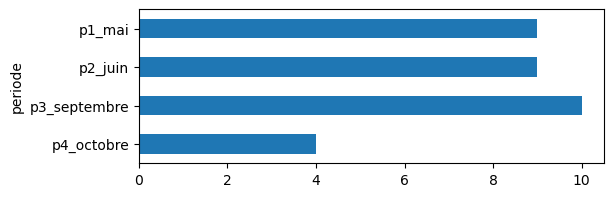

In [11]:
### group and count births
f = pg_q2.sort_index(ascending=False).plot(kind='barh', figsize=(6,2))


In [22]:
## Calculate the pivot table 

X = 'periode'
Y = 'p_c'

ddf = g_q2[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf

p_c,France_autre,France_manif,France_meeting,Suisse_autre,Suisse_manif,Suisse_meeting,Total
periode,,,,,,,
p1_mai,3,3,0,1,1,1,9
p2_juin,2,1,1,0,1,4,9
p3_septembre,1,1,0,1,1,6,10
p4_octobre,1,1,0,2,0,0,4
Total,7,6,1,4,3,11,32


In [23]:
## Total number
n = ddf.iloc[-1,-1]
print(n)

32


In [24]:
## Pivot table without borders
D = ddf.iloc[:-1,:-1].copy(deep=True)
# D

In [25]:
### Valeurs produites par une fonction
statistic, p, dof, expected = stats.chi2_contingency(D)

print('Chi2 :', statistic, ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),1)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D, method='cramer')
print('Cramer: ', vc)

Chi2 : 16.644925444925445 , dof : 15
p-value : 0.34052995351424725
phi2 = inertie (variance totale) : 0.5201539201539201
Cramer:  0.4163948127094125


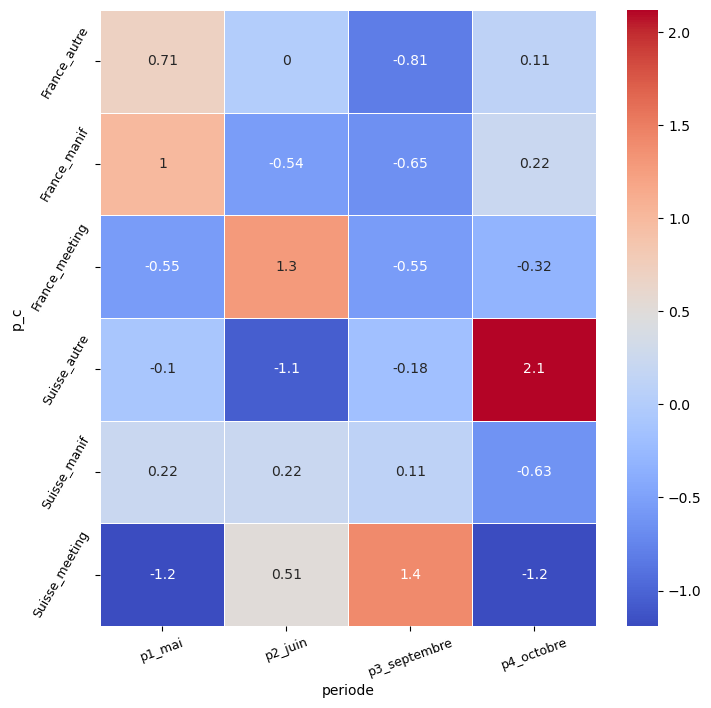

In [26]:
### Résidus pondérés (avec le signe)
### Doc. :
#   Rakotomalala, p.240
residus_ponderes = (round((D.values-dfe)/np.sqrt(dfe),2))
residus_ponderes.columns= D.columns
residus_ponderes.index=D.index

residus_ponderes_T = residus_ponderes.transpose()

fig, ax = plt.subplots(figsize=(8,8))
# Sample figsize in inches
g = sns.heatmap(residus_ponderes_T, annot=residus_ponderes_T, 
                cmap="coolwarm", linewidths=.5, ax=ax,
                annot_kws={"fontsize":10})
labels = residus_ponderes_T.index
cols = residus_ponderes_T.columns
c = g.set_xticklabels(cols, rotation=20, size=9)
p = g.set_yticklabels(labels, rotation=60, size=9)

plt.savefig('pictures/pays_classif_periode.jpg')

plt.show()


In [17]:
## Calculate the pivot table 

X = 'pays'
Y = 'classif'

ddf = g_q2[[X,Y]].pivot_table(index=X,columns=Y,aggfunc=len,margins=True,margins_name="Total").fillna(0).astype(int)
ddf

classif,autre,manif,meeting,Total
pays,,,,
France,7,6,1,14
Suisse,4,3,11,18
Total,11,9,12,32


In [18]:
## Total number
n = ddf.iloc[-1,-1]
print(n)

32


In [19]:
## Pivot table without borders
D = ddf.iloc[:-1,:-1].copy(deep=True)
# D

In [20]:
### Valeurs produites par une fonction
statistic, p, dof, expected = stats.chi2_contingency(D)

print('Chi2 :', statistic, ', dof :',dof)
print('p-value :', p)


print('phi2 = inertie (variance totale) :', statistic/n)


### Tableau à l'indépendance
dfe = round(pd.DataFrame(expected),1)

### Coéfficient de Cramer
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.contingency.association.html

vc = stats.contingency.association(D, method='cramer')
print('Cramer: ', vc)

Chi2 : 9.804713804713804 , dof : 2
p-value : 0.007429052868336513
phi2 = inertie (variance totale) : 0.3063973063973064
Cramer:  0.5535316670230407


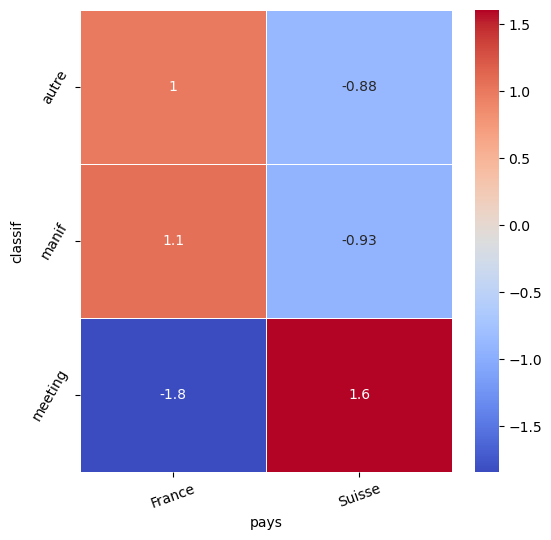

In [21]:
### Résidus pondérés (avec le signe)
### Doc. :
#   Rakotomalala, p.240
residus_ponderes = (round((D.values-dfe)/np.sqrt(dfe),2))
residus_ponderes.columns= D.columns
residus_ponderes.index=D.index

residus_ponderes_T = residus_ponderes.transpose()

fig, ax = plt.subplots(figsize=(6,6))
# Sample figsize in inches
g = sns.heatmap(residus_ponderes_T, annot=residus_ponderes_T, 
                cmap="coolwarm", linewidths=.5, ax=ax,
                annot_kws={"fontsize":10})
labels = residus_ponderes_T.index
cols = residus_ponderes_T.columns
c = g.set_xticklabels(cols, rotation=20, size=10)
p = g.set_yticklabels(labels, rotation=60, size=10)

plt.savefig('pictures/pays_classif.png')

plt.show()
